In [27]:
from pathlib import Path

import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import build_dataloader
from models import YOLOv3_Model
from utils import visualize

In [2]:
ROOT = Path.cwd()

EXP_NAME = 'test03'
data_path = ROOT / 'data' / 'coco128.yml'
config_path = ROOT / 'config' / 'yolov3.yml'
save_path = ROOT / 'experiments' / EXP_NAME

In [3]:
with open(config_path) as f:
    item = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
log_level = item['LOG_LEVEL']
is_cuda = False
num_epochs = item['NUM_EPOCHS']
input_size = item['INPUT_SIZE']
batch_size = 1

device = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
dataloaders, classname_list = build_dataloader(data_path=data_path, 
                                               image_size=(input_size, input_size),
                                               batch_size=batch_size)
num_classes = len(classname_list)
model = YOLOv3_Model(config_path=config_path, num_classes=num_classes, device=device)
model = model.to(device)

[TRAIN] hash: 22207404  version: 2022-06-30_22:28  
[VAL] hash: 7499800  version: 2022-07-04_21:13  


In [44]:
def denormalize(input_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    tensor = input_tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor.clamp_(min=0, max=1.)
    tensor *= 255.
    image = tensor.permute(1,2,0).numpy().astype(np.uint8)
    return image

def filter_conf_score(prediction, conf_threshold=0.01):
    valid_score_index = (prediction[..., 4] > conf_threshold)
    bboxes = prediction[:, :4][valid_score_index]
    conf_scores = prediction[:, 4][valid_score_index]
    class_probs = np.argmax(prediction[:, 5:][valid_score_index], axis=1)
    return np.concatenate([bboxes, conf_scores[:, np.newaxis], class_probs[:, np.newaxis]], axis=-1)

def run_NMS_yolo_format(bboxes, iou_threshold=0.1):
    if len(bboxes) == 0:
        return []
    if bboxes.dtype.kind == "i":
        bboxes = bboxes.astype("float")
    pick = []
    x1 = bboxes[:, 0] - bboxes[:, 2]/2
    y1 = bboxes[:, 1] - bboxes[:, 3]/2
    x2 = bboxes[:, 0] + bboxes[:, 2]/2
    y2 = bboxes[:, 1] + bboxes[:, 3]/2
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > iou_threshold)[0])))
    return pick

def cxcywh_to_x1y1x2y2(bboxes, input_size):
    xy_min = bboxes[:, 0:2] - bboxes[:, 2:4] / 2
    xy_max = bboxes[:, 0:2] + bboxes[:, 2:4] / 2
    xy_min = xy_min.clip(min=0.)
    xy_max = xy_max.clip(max=input_size)
    return np.concatenate((xy_min, xy_max), axis=1).astype(int)

In [66]:
phase = 'val'
conf_threshold = 0.5
iou_threshold = 0.4

for index, mini_batch in enumerate(dataloaders["train"]):
    images = mini_batch[0].to(device)
    targets = mini_batch[1]
    filenames = mini_batch[2]
    
    with torch.no_grad():
        predictions = model(images)
        
    if phase == 'val':
        canvas_image = denormalize(images[0])
        prediction = torch.cat(predictions, dim=1)[0]
        prediction = prediction.cpu().numpy()
        
        pred_res = filter_conf_score(prediction, conf_threshold=conf_threshold)
        valid_index = run_NMS_yolo_format(bboxes=pred_res[:, :4], iou_threshold=iou_threshold)
        pred_res = pred_res[valid_index]
        
    if index == 0:
        break

In [74]:
pred_res

array([[3.03659332e+02, 2.44218109e+02, 4.93250336e+02, 1.05564404e+03,
        5.41403413e-01, 2.60000000e+01],
       [1.39547825e+01, 3.68440460e+02, 1.10025223e+02, 3.64130585e+02,
        6.24897778e-01, 3.90000000e+01],
       [1.15505295e+01, 3.72081055e+02, 4.29345825e+02, 2.97267029e+02,
        5.54868460e-01, 1.00000000e+00],
       [1.76565418e+01, 1.44795868e+02, 1.46198837e+02, 2.27105042e+02,
        5.38272381e-01, 2.70000000e+01],
       [7.26101151e+01, 2.06526527e+01, 1.26351685e+03, 3.15200500e+02,
        5.88024616e-01, 7.40000000e+01]])

In [67]:
[classname_list[int(i)] for i in pred_res[:,5]]

['handbag', 'bottle', 'bicycle', 'tie', 'clock']

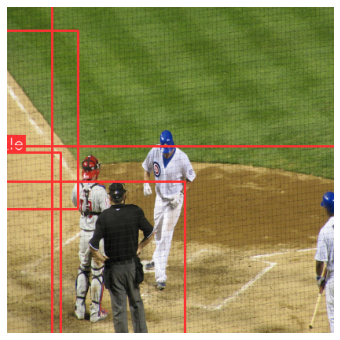

In [68]:
canvas = visualize(canvas_image, pred_res[:,:4], pred_res[:,5], classname_list)

plt.figure(figsize=(6,6))
plt.imshow(canvas)
plt.axis('off')
plt.show()